# Random Forest on Top 30 features

## Data Preprocessing

In [35]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.cluster import KMeans
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

## Extract 10000 case_id's for num_group = 0.

In [2]:
def merge_n_case_ids(
    n_ids: int = 10000,
    data_dir: str = '/kaggle/input/cr-newagg/new_aggs',
    path_to_base: str = '/kaggle/input/datasets-cr/train_base.parquet',
    use_0: bool = True,
    as_pandas: bool = True,
    random_state: int = 28
) -> pl.DataFrame | pd.DataFrame:
    '''
    Function to merge selected case_id from parquet files, returns subset case_id from the merged dataset.

    Parameters
    ----------
    n_ids : Number of case_ids to sample initially and return (int)
    data_dir : Path to processed parquet files directory (str)
    path_to_base : Path to base file (str)
    use_0 : Use num_group1 == 0 (bool)
    as_pandas : Return as pandas DataFrame
    random_seed : Random seed (int)
    '''
    # Read the base dataframe and sample case_ids
    if as_pandas:
        base_df = pd.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, random_state=random_state).tolist()
    else:
        base_df = pl.read_parquet(path_to_base)
        case_ids = base_df['case_id'].sample(n=n_ids, replace=False, seed=random_state).to_list()

    # Define the file pattern for fetching files
    file_pattern = '*grouped_0.parquet' if use_0 else '*grouped_rest.parquet'
    file_paths = glob(data_dir + '/' + file_pattern)

    # Initialize the merged DataFrame filtering the base DataFrame
    if as_pandas:
        df = base_df[base_df['case_id'].isin(case_ids)]
    else:
        df = base_df.filter(pl.col('case_id').is_in(case_ids))

    # Merge DataFrames with only the selected case_ids
    for path in file_paths:
        if as_pandas:
            temp = pd.read_parquet(path)
            temp = temp[temp['case_id'].isin(case_ids)]
            df = pd.merge(df, temp, on='case_id', how='outer')
        else:
            temp = pl.read_parquet(path)
            temp = temp.filter(pl.col('case_id').is_in(case_ids))
            df = df.join(temp, on='case_id', how='outer')

    # Convert to pandas if required and using Polars
    if as_pandas and isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    return df

In [3]:
df = merge_n_case_ids(
    n_ids=10000,
    data_dir='/kaggle/input/cr-newagg/new_aggs',
    path_to_base='/kaggle/input/datasets-cr/train_base.parquet',
    use_0=True,
    as_pandas=True,
    random_state=28  
)

In [5]:
# Extract date info from base
df['date_decision'] = pd.to_datetime(df['date_decision'])
df['dec_day'] = df['date_decision'].dt.day
df['dec_month'] = df['date_decision'].dt.month
df['dec_year'] = df['date_decision'].dt.year

# Drop redundant information
df = df.drop(columns=[
    'date_decision'
])

In [6]:
df.head()

,case_id,MONTH,WEEK_NUM,target,amount_4527230A_min,amount_4527230A_max,amount_4527230A_mean,amount_4527230A_median,amount_4527230A_sum,recorddate_4527225D_min,...,openingdate_857D_distinct,openingdate_857D_min_year,openingdate_857D_min_month,openingdate_857D_min_day,openingdate_857D_max_year,openingdate_857D_max_month,openingdate_857D_max_day,dec_day,dec_month,dec_year
0,4,201901,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2019
1,134,201901,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2019
2,199,201901,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,2019
3,496,201901,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1,2019
4,672,201901,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2019


In [8]:
object_cols = ['recorddate_4527225D_min', 'recorddate_4527225D_max', 'dateofcredend_289D_min', 'dateofcredend_353D_min', 'dateofcredstart_181D_min', 'dateofcredstart_739D_min', 
               'dateofrealrepmt_138D_min', 'lastupdate_1112D_min', 
               'lastupdate_388D_min', 'numberofoverdueinstlmaxdat_148D_min', 'numberofoverdueinstlmaxdat_641D_min', 'overdueamountmax2date_1002D_min', 'overdueamountmax2date_1142D_min', 'refreshdate_3813885D_min', 
               'dateofcredend_289D_max', 'dateofcredend_353D_max', 'dateofcredstart_181D_max', 'dateofcredstart_739D_max', 'dateofrealrepmt_138D_max', 'lastupdate_1112D_max', 'lastupdate_388D_max', 
               'numberofoverdueinstlmaxdat_148D_max', 'numberofoverdueinstlmaxdat_641D_max', 'overdueamountmax2date_1002D_max', 'overdueamountmax2date_1142D_max', 'refreshdate_3813885D_max', 
               'contractenddate_991D_min', 'openingdate_313D_min', 
               'contractenddate_991D_max', 'openingdate_313D_max', 'pmts_date_1107D_min', 'pmts_date_1107D_max', 'approvaldate_319D_min', 'creationdate_885D_min', 
               'dateactivated_425D_min', 'dtlastpmt_581D_min', 'dtlastpmtallstes_3545839D_min', 'employedfrom_700D_min', 'firstnonzeroinstldate_307D_min', 'approvaldate_319D_max', 
               'creationdate_885D_max', 'dateactivated_425D_max', 'dtlastpmt_581D_max', 'dtlastpmtallstes_3545839D_max', 'employedfrom_700D_max', 'firstnonzeroinstldate_307D_max', 
               'empls_employedfrom_796D_min', 'empls_employedfrom_796D_max', 'processingdate_168D_min', 'processingdate_168D_max', 'contractdate_551D_min', 'contractmaturitydate_151D_min', 
               'lastupdate_260D_min', 'contractdate_551D_max', 'contractmaturitydate_151D_max', 'lastupdate_260D_max', 'birth_259D_min', 'birthdate_87D_min', 'empl_employedfrom_271D_min', 
               'birth_259D_max', 'birthdate_87D_max', 'empl_employedfrom_271D_max', 'deductiondate_4917603D_min', 'deductiondate_4917603D_max', 'openingdate_857D_min', 'openingdate_857D_max']

# Drop the object columns from the DataFrame
df.drop(columns=object_cols, inplace=True)

# Print the new DataFrame information to confirm columns are deleted
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1360 entries, case_id to dec_year
dtypes: float64(1230), int32(5), int64(4), int8(99), object(14), uint32(8)
memory usage: 96.7+ MB
None


In [9]:
df.fillna(df.mean(), inplace=True)

# Model Building: Random Forest on top 30 features

In [10]:
# Count the occurrences of each unique value in 'target'
value_counts = df['target'].value_counts().reset_index()
value_counts.columns = ['target', 'count']

# Calculate the total number of rows in the DataFrame
total_count = df.shape[0]  # This returns the number of rows

# Calculate the proportion of each 'target' value
value_counts['proportion'] = value_counts['count'] / total_count

# Print the result
print(value_counts)

   target  count  proportion
0       0   9667      0.9667
1       1    333      0.0333


The ratio of fraud to non-fraud observations is very low. Need to use techniques such as oversampling the minority class, undersampling the majority class, or using synthetic data generation methods like SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes before model training.

In [11]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target'] 

print(X.head()) 
print(y.head())

   case_id   MONTH  WEEK_NUM  amount_4527230A_min  amount_4527230A_max  \
0        4  201901         0          2360.487549          2360.487549   
1      134  201901         0          2360.487549          2360.487549   
2      199  201901         0          2360.487549          2360.487549   
3      496  201901         1          2360.487549          2360.487549   
4      672  201901         1          2360.487549          2360.487549   

   amount_4527230A_mean  amount_4527230A_median  amount_4527230A_sum  \
0           2360.487549             2360.487549          2360.487549   
1           2360.487549             2360.487549          2360.487549   
2           2360.487549             2360.487549          2360.487549   
3           2360.487549             2360.487549          2360.487549   
4           2360.487549             2360.487549          2360.487549   

   recorddate_4527225D_distinct  recorddate_4527225D_min_year  ...  \
0                           1.0                   20

____________________________________________________________________________________________________

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


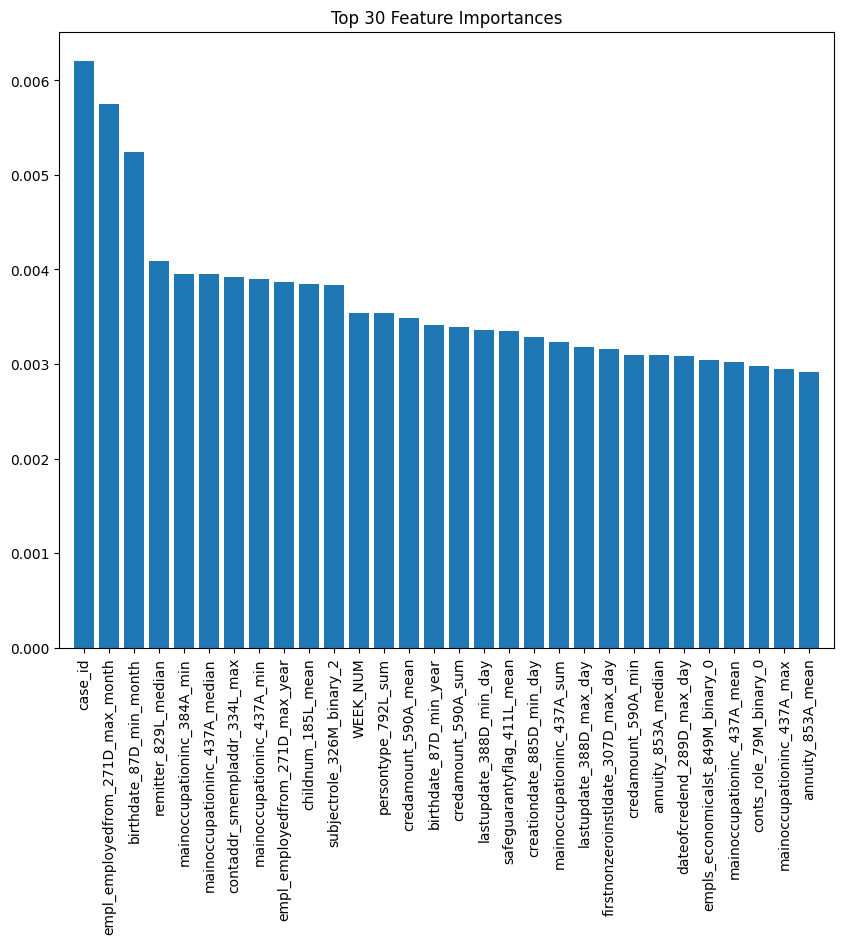

In [13]:
# Create an imputer object that fills in missing values with the mean of the column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Create a pipeline that first imputes the missing values, then fits a RandomForestClassifier
pipeline = Pipeline([
    ('imputer', imputer),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model on the training data
pipeline.fit(X, y)

# Extract the feature importances from the classifier
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plotting only the top 30 features for readability
plt.figure(figsize=(10, 8))
plt.title("Top 30 Feature Importances")
plt.bar(range(30), importances[indices[:30]], align='center')
plt.xticks(range(30), X.columns[indices[:30]], rotation=90)
plt.xlim([-1, 30])
plt.show()

In [14]:
top_30_indices = indices[:30]
top_30_features = X.columns[top_30_indices]

# Create a new DataFrame with only the top 30 features
X_top_30 = X[top_30_features]


In [15]:
# Assuming 'top_30_features' is a list of the column names for the top 30 features
X_train_top30 = X_train[top_30_features]
X_test_top30 = X_test[top_30_features]


Accuracy: 0.83
Precision: 0.06
Recall: 0.25
AUC: 0.58
F1 Score: 0.10


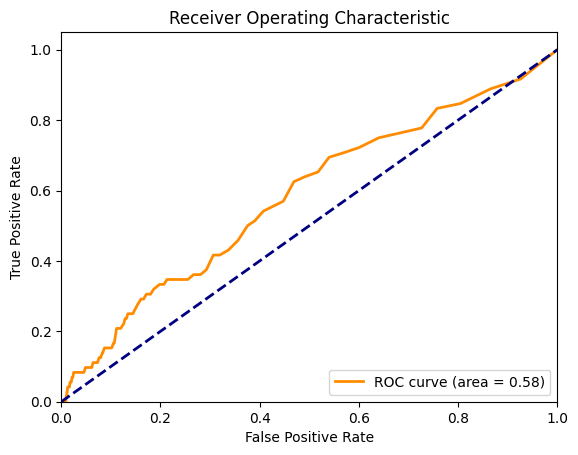

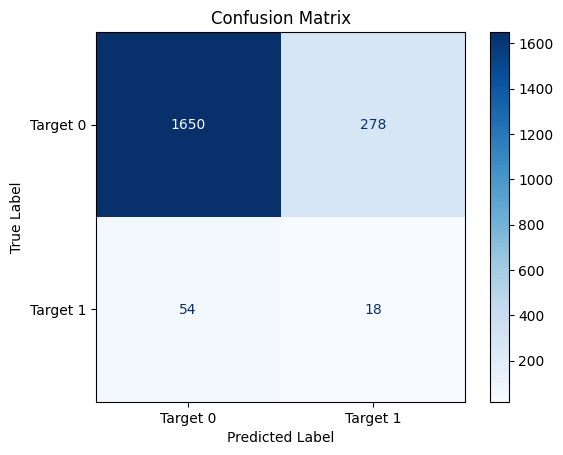

In [16]:
# Define the pipeline using imblearn's Pipeline
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),  # Imputing missing values
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=None, class_weight={0: 1, 1: 10}, random_state=42))
])

pipeline.fit(X_train_top30, y_train)
y_proba = pipeline.predict_proba(X_test_top30)[:, 1]

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate metrics
threshold = 0.2 
y_pred_adjusted = (y_proba > threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
auc_score = roc_auc_score(y_test, y_proba)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'AUC: {auc_score:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for adjusted threshold predictions
cm = confusion_matrix(y_test, y_pred_adjusted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Target 0', 'Target 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Random Forest Classifier using StratifiedKFold

Accuracy: 0.94
Precision: 0.06
Recall: 0.06
AUC: 0.66
F1 Score: 0.06


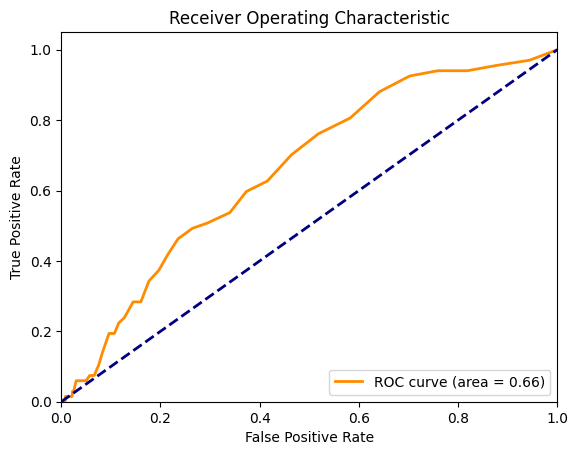

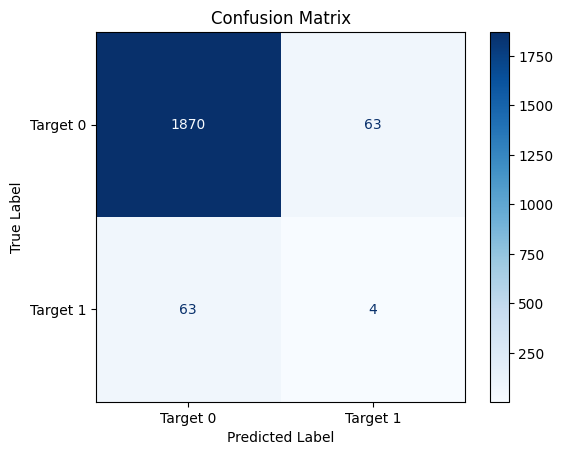

Accuracy: 0.94
Precision: 0.05
Recall: 0.04
AUC: 0.68
F1 Score: 0.05


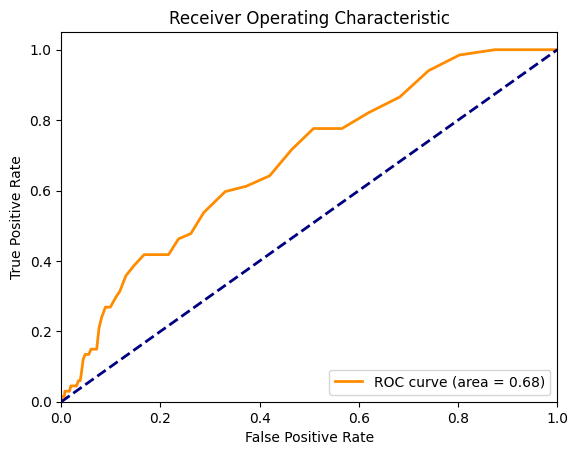

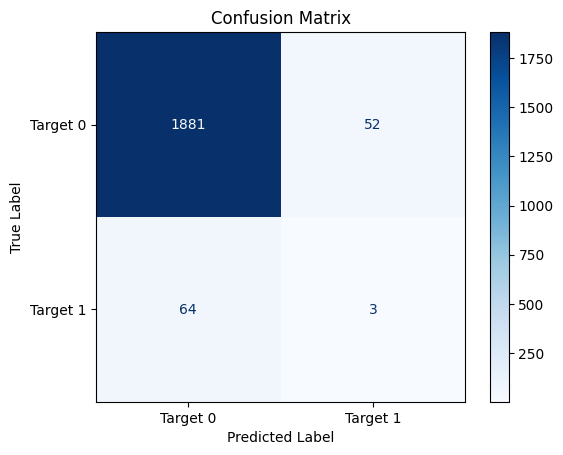

Accuracy: 0.94
Precision: 0.07
Recall: 0.07
AUC: 0.69
F1 Score: 0.07


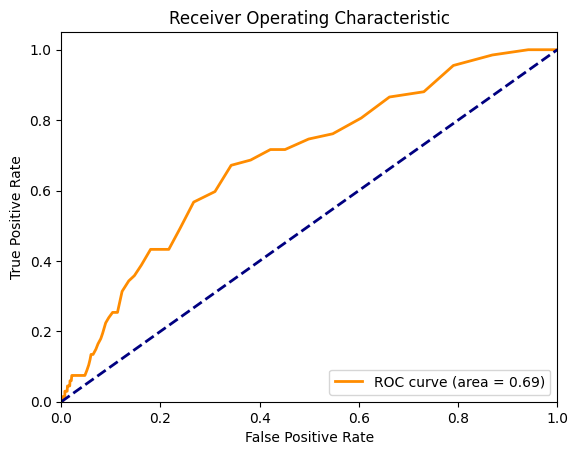

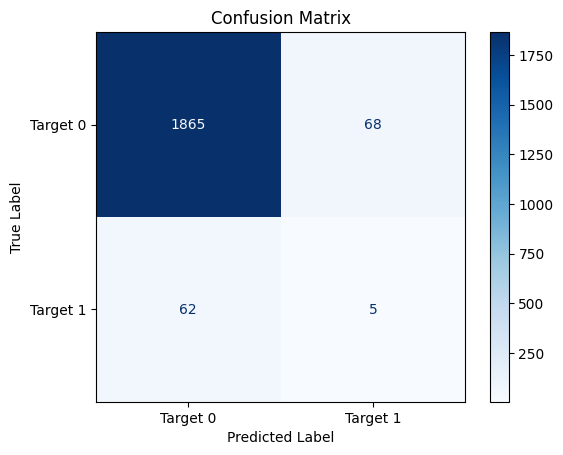

Accuracy: 0.95
Precision: 0.10
Recall: 0.06
AUC: 0.70
F1 Score: 0.08


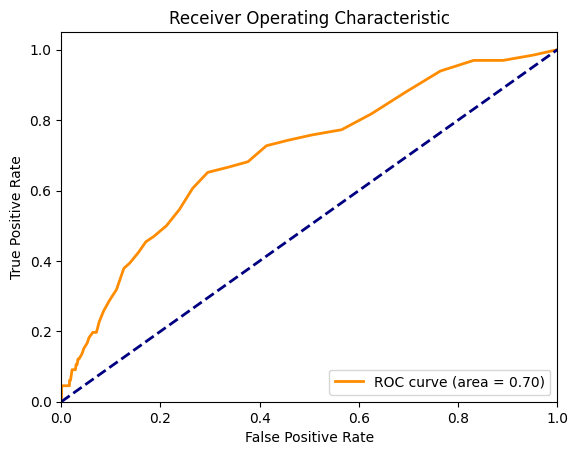

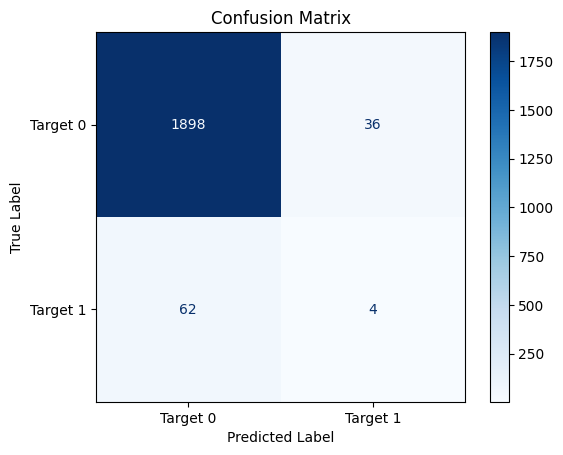

Accuracy: 0.95
Precision: 0.11
Recall: 0.08
AUC: 0.71
F1 Score: 0.09


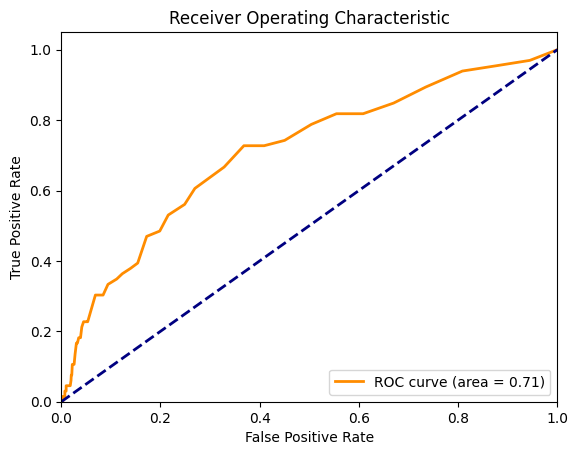

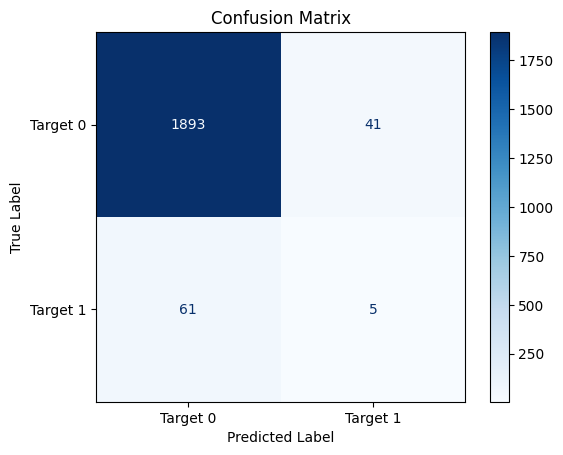

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Convert X and y to numpy arrays
X = X.values
y = y.values

# Define the pipeline using imblearn's Pipeline
pipeline = ImbPipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),  # Imputing missing values
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=None, class_weight={0: 1, 1: 10}, random_state=42))
])

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities for the test set
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Generate ROC curve data
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Calculate metrics
    threshold = 0.2 
    y_pred_adjusted = (y_proba > threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    auc_score = roc_auc_score(y_test, y_proba)

    # Print metrics for each fold
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'AUC: {auc_score:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Plot ROC Curve for each fold
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix for adjusted threshold predictions for each fold
    cm = confusion_matrix(y_test, y_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Target 0', 'Target 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Performed a stratified cross-validation using StratifiedKFold and evaluated a RandomForestClassifier pipeline on each fold, computing and displaying various evaluation metrics for each fold. 

This approach helps in getting a more reliable estimate of the model's performance across different subsets of the data.

_______________________________________________________________________________________________________

## Standardization

In [47]:
from sklearn.preprocessing import StandardScaler

# Standardize the training and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## LDA

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA for dimensionality reduction
lda = LDA()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)


## SMOTE

In [49]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on the training data
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_lda, y_train)


## Hyperparameter Tuning with RandomForest

In [52]:
# Define hyperparameters grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
model_rf = RandomForestClassifier(random_state=1)

# Configure RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_iter=50, 
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=2,
    random_state=1
)

# Fit the model on the resampled training data
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model_rf = random_search_rf.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   7.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   6.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   4.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200

In [53]:
best_model_rf

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400, random_state=1)

In [54]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Predict using the best model on the test set
y_test_pred = best_model_rf.predict(X_test_lda)
y_test_pred_probs = best_model_rf.predict_proba(X_test_lda)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_pred_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))


Accuracy: 0.775
ROC AUC: 0.5903498155832181
Confusion Matrix:
 [[1526  402]
 [  48   24]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      1928
           1       0.06      0.33      0.10        72

    accuracy                           0.78      2000
   macro avg       0.51      0.56      0.48      2000
weighted avg       0.94      0.78      0.84      2000



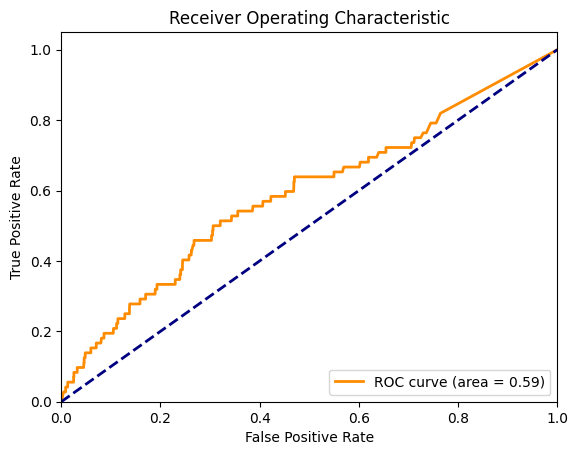

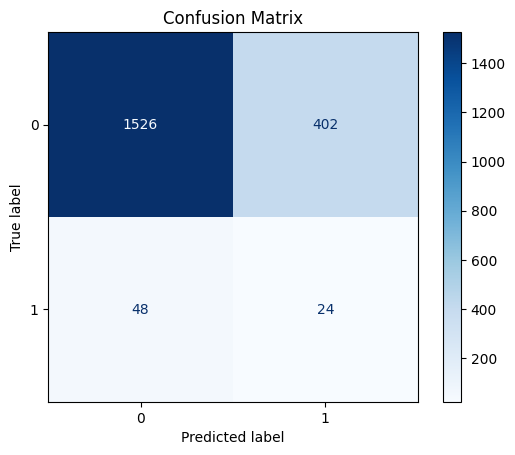

In [57]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.775 - This indicates that 77.5% of all predictions were correct. While this might seem high, it is misleading given the class imbalance.

ROC AUC: 0.590 - The AUC score is close to 0.5, which implies that the model does only slightly better than random guessing in distinguishing between the positive and negative classes.

Precision (Class 1): 0.06 - Very low, indicating that when the model predicts an instance as positive, it is correct only 6% of the time.

Recall (Class 1): 0.33 - This is also quite low, indicating that it correctly identifies 33% of all actual positives.

F1-Score (Class 1): 0.10 - The F1 score for the positive class is very low, reflecting the poor performance of both precision and recall.

While the model performs adequately in identifying the majority class, it struggles significantly with the minority class.

Use more effective algorithms than RandomForest like LightGBM.This can be effective and can improve performance particularly in scenarios involving complex relationships and class imbalances. 